## Imports and Environment Setup

This section imports necessary libraries and sets up the environment, checking for GPU availability which is crucial for accelerating the training process.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Loading and Preprocessing

Here we load the dataset and perform necessary preprocessing steps. This often involves normalizing the data and potentially augmenting it to improve model robustness.

In [2]:
import os
import torch
import random
import time
import cv2

from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
# import face_recognition
import glob

import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
SEED =  0

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)

is_gpu_available = torch.cuda.is_available()
print(f'Is using GPU: {is_gpu_available}')
device = torch.device('cuda' if is_gpu_available else 'cpu')

Is using GPU: True


## Model Building

In this part, we define our model architecture. We specify layers, activation functions, and compile the model with a loss function and optimizer.

In [4]:
class MultiLabelImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelImageClassifier, self).__init__()
        self.base_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

In [5]:
IMG_SIZE = 224

transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomCrop(IMG_SIZE, padding=IMG_SIZE//8),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),

    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 

    transforms.ToTensor(),
])
    
transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

## Training the Model

This section contains the training loop where the model is trained over several epochs. We feed the training data batch-by-batch, performing backpropagation to update the weights.

In [6]:
root_dataset = "/kaggle/input/celeb-df-deep-learning/dataset_img/dataset_img"

# Load the training data
train_dataset = torchvision.datasets.ImageFolder(root=root_dataset+'/train', transform=transform_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Load the validation data
val_dataset = torchvision.datasets.ImageFolder(root=root_dataset+'/val', transform=transform_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
EPOCHS = 50
model = MultiLabelImageClassifier(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0, total_iters=EPOCHS)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


## Evaluation and Testing

After training, we evaluate the model's performance on a validation set to see how well it generalizes to new, unseen data.

In [8]:
def one_hot_encode(labels, num_classes):
    labels = labels.to(device)
    
    # Create a tensor of zeros with the shape (len(labels), num_classes)
    one_hot_labels = torch.zeros(len(labels), num_classes, device=device)
    
    # Use torch.scatter_ to fill the ones in the appropriate indices
    one_hot_labels.scatter_(1, labels.unsqueeze(1), 1)
    
    return one_hot_labels

## Visualization

We visualize the training process here, plotting metrics like accuracy and loss over the training period to analyze the learning progress.

In [9]:
stat_training_loss = []
stat_val_loss = []
stat_training_acc = []
stat_val_acc = []
min_val_loss = float("inf")

for epoch in range(EPOCHS):
    start_time = time.time()
    training_loss = 0
    training_acc = 0
    training_samples = 0
    val_loss = 0
    val_acc = 0
    val_samples = 0

    model.train()
    for train_images, train_labels in train_loader:
        
        train_images, train_labels = train_images.to(device), train_labels.to(device)

        batch_size = train_images.shape[0]
        optimizer.zero_grad()
        train_outputs = model(train_images)

        loss = criterion(train_outputs, one_hot_encode(train_labels, 2))
        loss.backward()
        optimizer.step()

        _, top_class = train_outputs.topk(1, dim=1)
        equals = top_class == train_labels.to(device).view(*top_class.shape)
        training_acc += torch.sum(equals.type(torch.FloatTensor)).item()

        training_loss += batch_size * loss.item()
        training_samples += batch_size

    model.eval()
    for val_imgs, val_labels in val_loader:

        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        
        batch_size = val_imgs.shape[0]
        outputs = model(val_imgs)

        loss = criterion(outputs, one_hot_encode(val_labels, 2))

        _, top_class = outputs.topk(1, dim=1)
        equals = top_class == val_labels.to(device).view(*top_class.shape)
        val_acc += torch.sum(equals.type(torch.FloatTensor)).item()

        val_loss += batch_size * loss.item()
        val_samples += batch_size

    stat_training_loss.append(training_loss/training_samples)
    stat_val_loss.append(val_loss/val_samples)
    stat_training_acc.append(training_acc/training_samples)
    stat_val_acc.append(val_acc/val_samples)


    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {(epoch+1):d}/{EPOCHS}.. Learning rate: {scheduler.get_lr()[0]:.4f}.. Train loss: {(training_loss/training_samples):.4f}.. Train acc: {(training_acc/training_samples):.4f}.. Val loss: {(val_loss/val_samples):.4f}.. Val acc: {(val_acc/val_samples):.4f}  Time: {epoch_time:.2f} seconds")
    
    if min_val_loss > (val_loss/val_samples):
        min_val_loss = (val_loss/val_samples)
        torch.save(model.state_dict(), f'./model_epoch{(epoch+1):d}.pth')
        print("Saving model...")

    print()
    scheduler.step()

Epoch 1/50.. Learning rate: 0.0010.. Train loss: 0.5527.. Train acc: 0.7463.. Val loss: 0.6143.. Val acc: 0.6800  Time: 213.01 seconds
Saving model...



/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:486: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 2/50.. Learning rate: 0.0010.. Train loss: 0.5028.. Train acc: 0.8009.. Val loss: 0.5260.. Val acc: 0.7698  Time: 210.19 seconds
Saving model...

Epoch 3/50.. Learning rate: 0.0010.. Train loss: 0.4743.. Train acc: 0.8310.. Val loss: 0.4598.. Val acc: 0.8356  Time: 210.35 seconds
Saving model...

Epoch 4/50.. Learning rate: 0.0010.. Train loss: 0.4505.. Train acc: 0.8536.. Val loss: 0.4409.. Val acc: 0.8636  Time: 210.23 seconds
Saving model...

Epoch 5/50.. Learning rate: 0.0010.. Train loss: 0.4310.. Train acc: 0.8758.. Val loss: 0.4683.. Val acc: 0.8418  Time: 210.25 seconds

Epoch 6/50.. Learning rate: 0.0010.. Train loss: 0.4290.. Train acc: 0.8766.. Val loss: 0.4658.. Val acc: 0.8418  Time: 210.42 seconds

Epoch 7/50.. Learning rate: 0.0010.. Train loss: 0.4302.. Train acc: 0.8771.. Val loss: 0.5174.. Val acc: 0.7844  Time: 210.25 seconds

Epoch 8/50.. Learning rate: 0.0010.. Train loss: 0.4098.. Train acc: 0.8996.. Val loss: 0.4196.. Val acc: 0.8893  Time: 210.25 seconds
S

## Saving the Model or Results

Finally, we save the trained model or any important metrics to disk for later use or further analysis.

In [10]:
torch.save(model.state_dict(), "./model.pth")

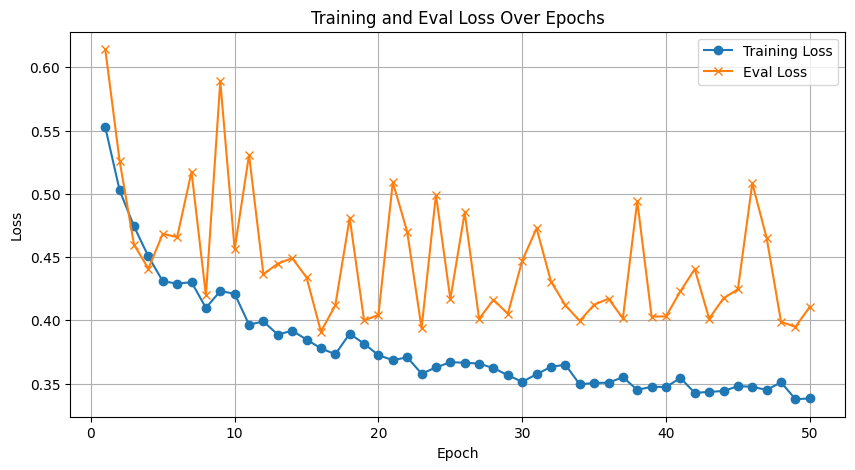

In [11]:
epochs_lst = list(range(1, EPOCHS+1))
plt.figure(figsize=(10, 5))
plt.plot(epochs_lst, stat_training_loss, label='Training Loss', marker='o')
plt.plot(epochs_lst, stat_val_loss, label='Eval Loss', marker='x')
plt.title('Training and Eval Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

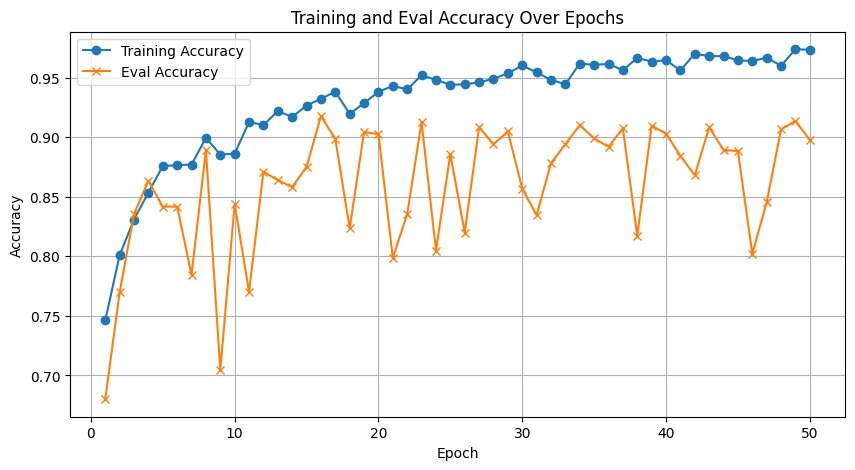

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_lst, stat_training_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_lst, stat_val_acc, label='Eval Accuracy', marker='x')
plt.title('Training and Eval Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()